In [3]:
%matplotlib inline

from collections import defaultdict
from collections import defaultdict
import scipy
import traceback
import os
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
import sys
import seaborn as sns; sns.set()  # for plot styling

import sklearn.cluster
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import pandas as pd
import scanpy.api as sc

#LOAD DATA

input_path = 'filtered_gene_bc_matrices/zv10_gtf89_cloche_gfp/'

if os.path.isfile(input_path + '/matrix.npz'):
    E = scipy.sparse.load_npz(input_path + '/matrix.npz')
else:
    E = scipy.io.mmread(input_path + '/matrix.mtx').T.tocsc()
    scipy.sparse.save_npz(input_path + '/matrix.npz', E, compressed=True)
    
gene_list = np.array(load_genes(input_path + 'genes.tsv',column = 1))

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()
results_file = '/write6/pmbc3k.h5ad'

scanpy==1.2.2 anndata==0.6.6 numpy==1.14.0 scipy==1.0.0 pandas==0.23.3 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1+4.bed07760 louvain==0.6.1 


In [5]:
path = 'filtered_gene_bc_matrices/10x/6hpf-WT/'
adata = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
adata.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]

... reading from cache file ./cache/filtered_gene_bc_matrices-10x-6hpf-WT-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
adata.var_names_make_unique()

In [7]:
adata
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
mito_genes


['mt-nd1',
 'mt-nd2',
 'mt-co1',
 'mt-co2',
 'mt-atp8',
 'mt-atp6',
 'mt-co3',
 'mt-nd3',
 'mt-nd4l',
 'mt-nd4',
 'mt-nd5',
 'mt-nd6',
 'mt-cyb']

In [9]:
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

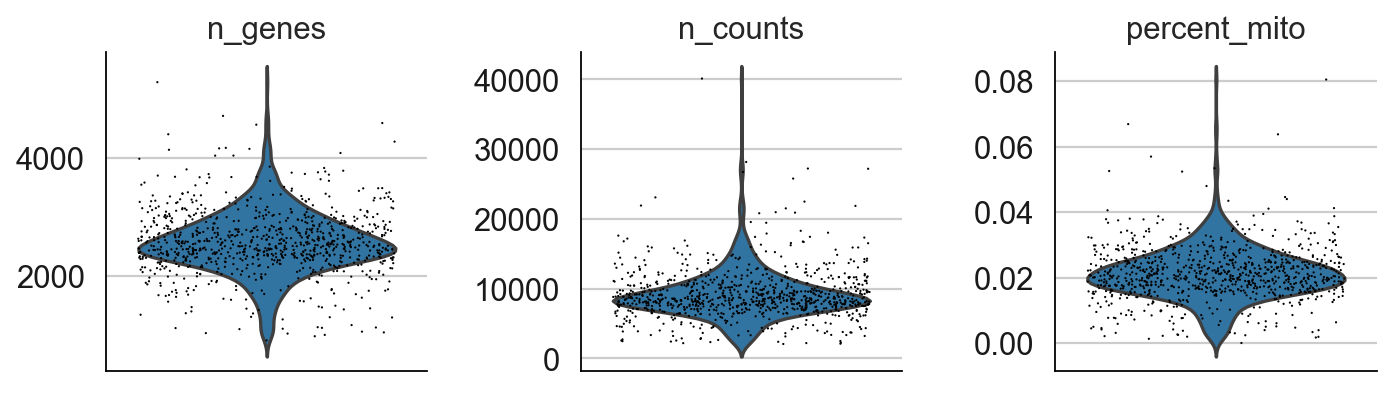

In [10]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

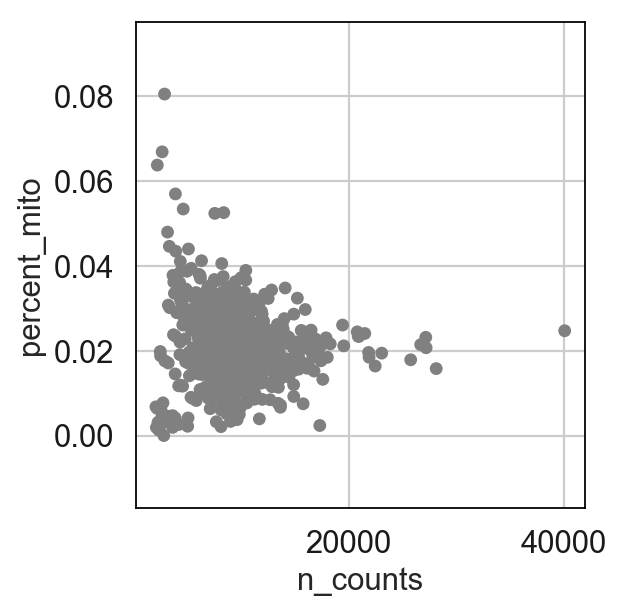

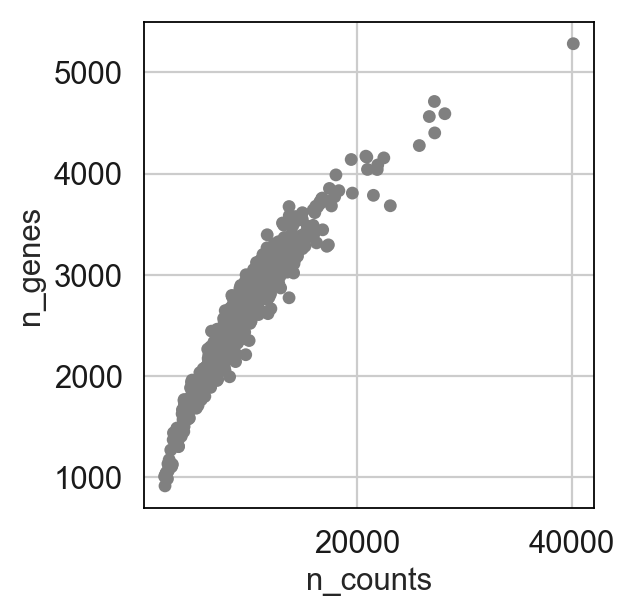

In [11]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [12]:
adata = adata[adata.obs['n_genes'] < 5000, :]
adata = adata[adata.obs['percent_mito'] < 0.04, :]

In [13]:
adata.raw = sc.pp.log1p(adata, copy=True)

In [14]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

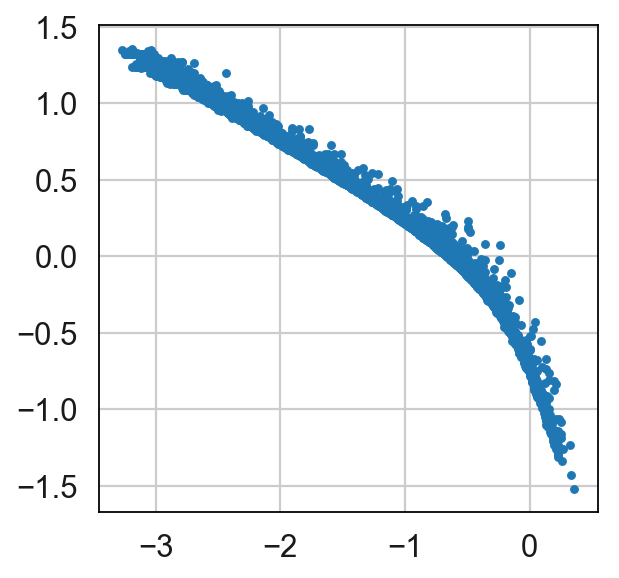

In [15]:
e = adata.X

e = e.toarray()
e = np.log10(e+1)
colmean = np.mean(e,axis=0)
colvar = np.var(e,axis=0)
sumcol = np.sum(e,axis=1)
colvar.shape
fig = plt.figure()
plt.scatter(np.log10(colmean),np.log10(np.sqrt(colvar)/colmean),marker='.')
#plt.hist(sumcol,bins=10)
#print(sumcol)

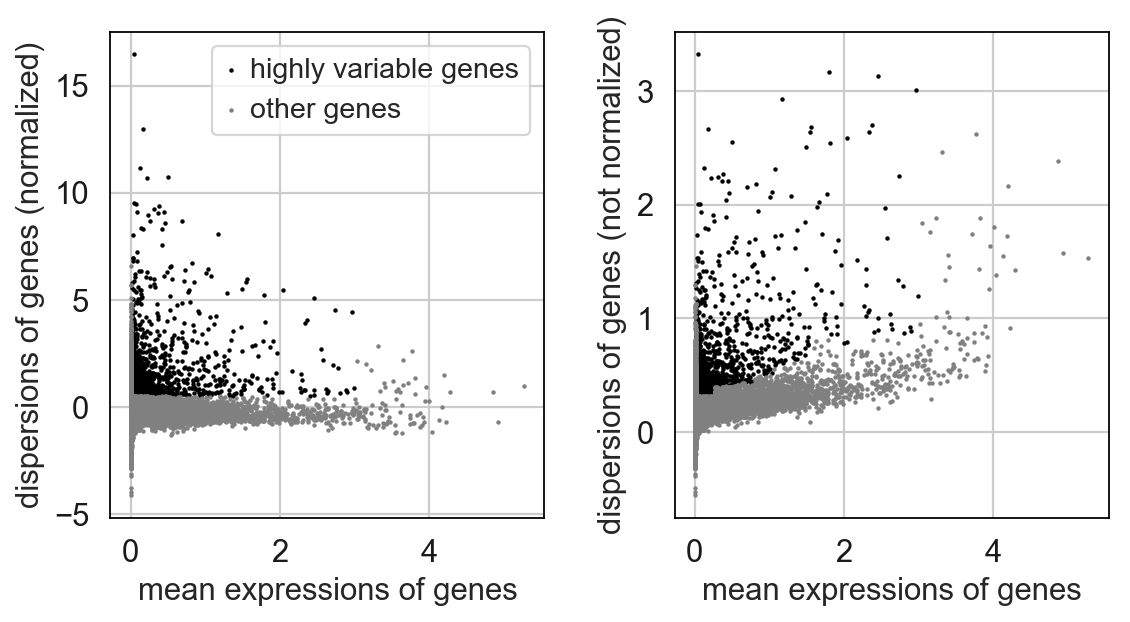

In [16]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)


In [17]:
adata = adata[:, filter_result.gene_subset]

In [18]:
sc.pp.log1p(adata)

In [19]:
#sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

In [20]:
sc.pp.scale(adata, max_value=10)

In [21]:
adata.write(results_file)

In [22]:
#PCA GRAPH

In [23]:
sc.tl.pca(adata)

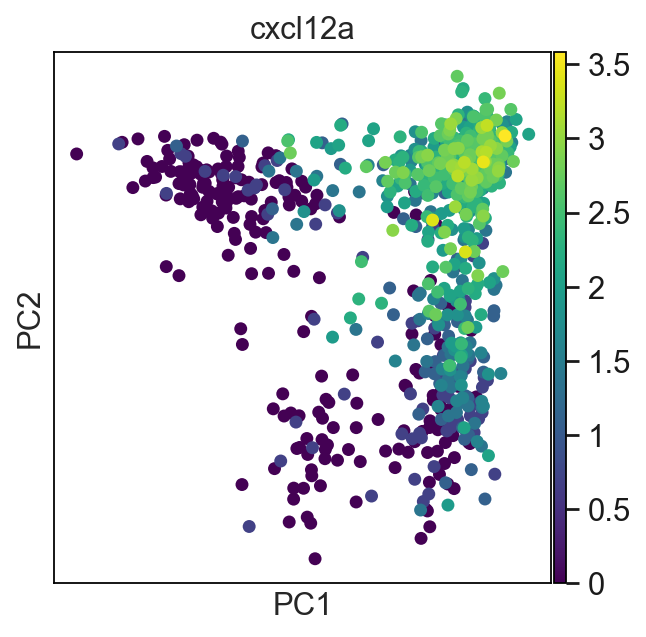

In [24]:
adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(adata,color='cxcl12a')

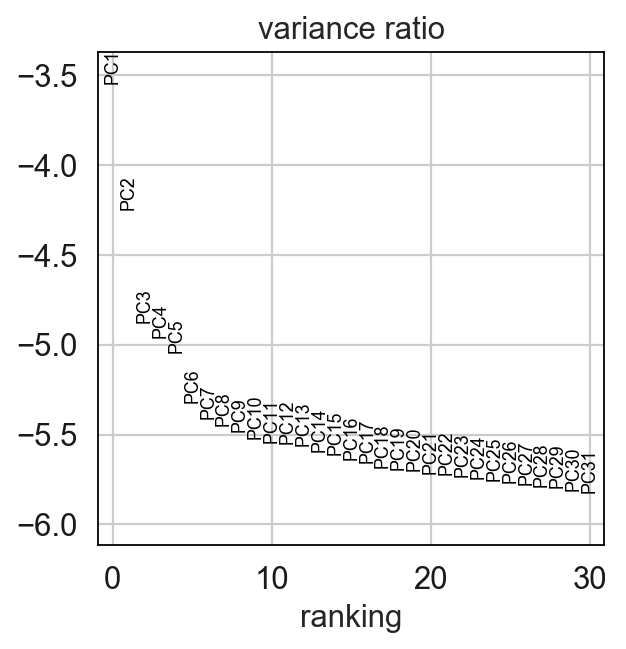

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

In [26]:
adata

AnnData object with n_obs × n_vars = 886 × 2139 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [27]:
adata.write(results_file)

In [28]:
### TSNE

In [29]:
sc.tl.tsne(adata, random_state=2, n_pcs=10)
adata.write(results_file)

computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:50.72) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


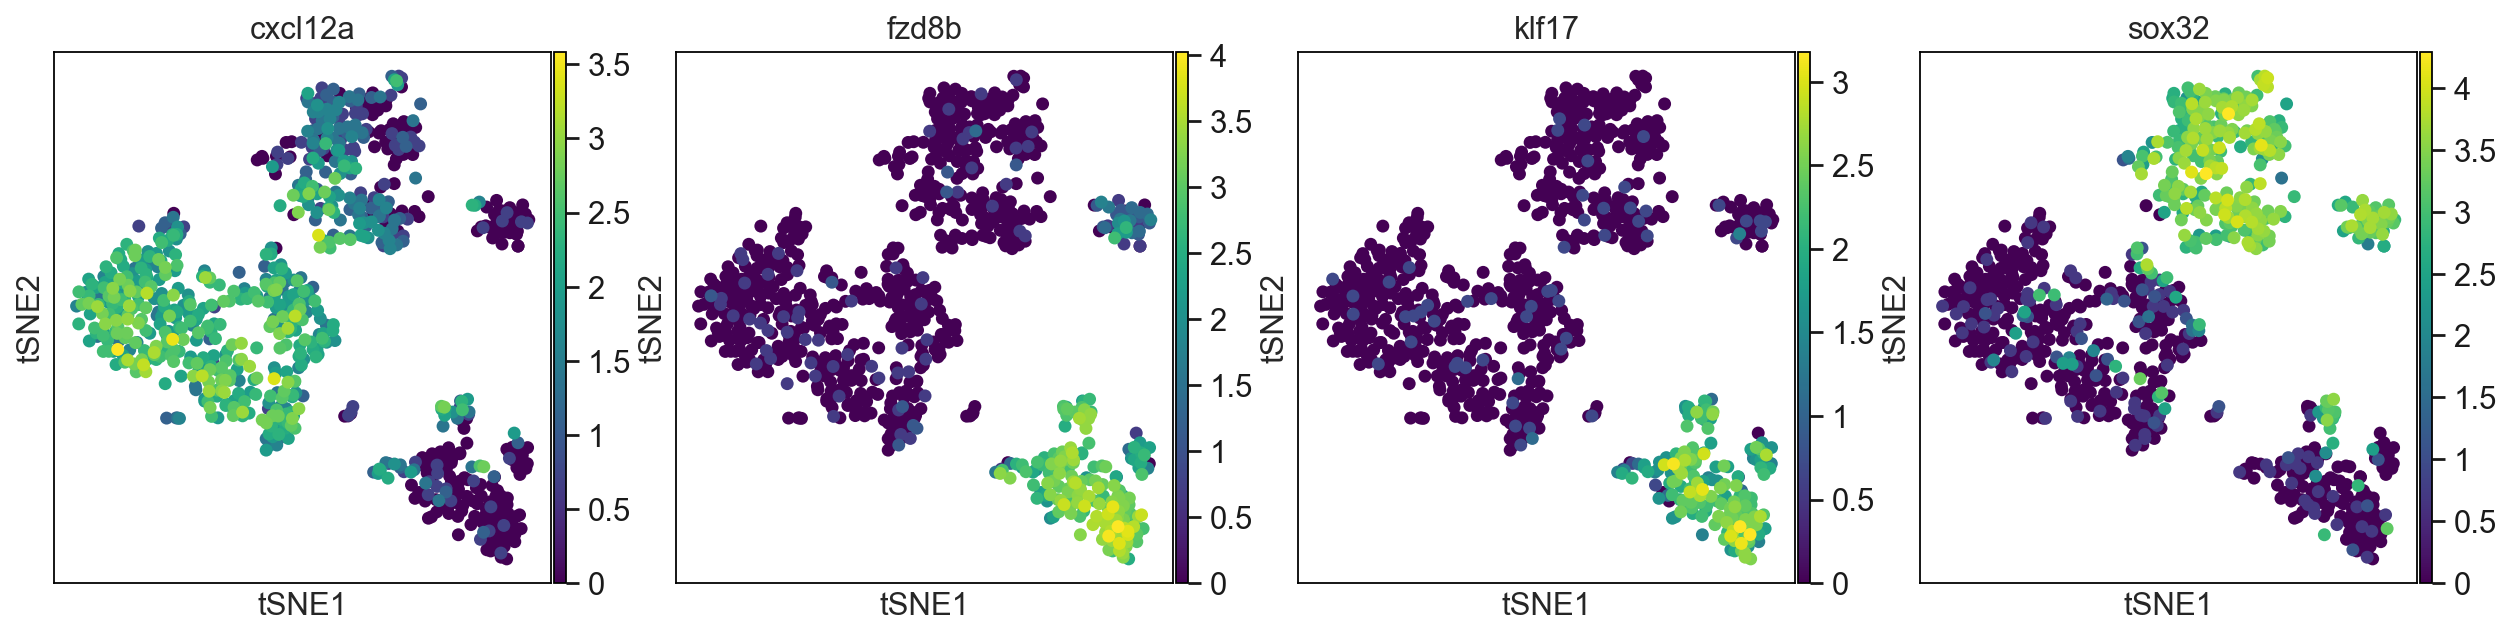

In [30]:
sc.pl.tsne(adata, color=['cxcl12a', 'fzd8b', 'klf17','sox32'])

In [31]:
adata = sc.read(results_file)

In [32]:
### Nearest Neighbour Graph

In [33]:
sc.pp.neighbors(adata, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:12.19) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [34]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:07.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)


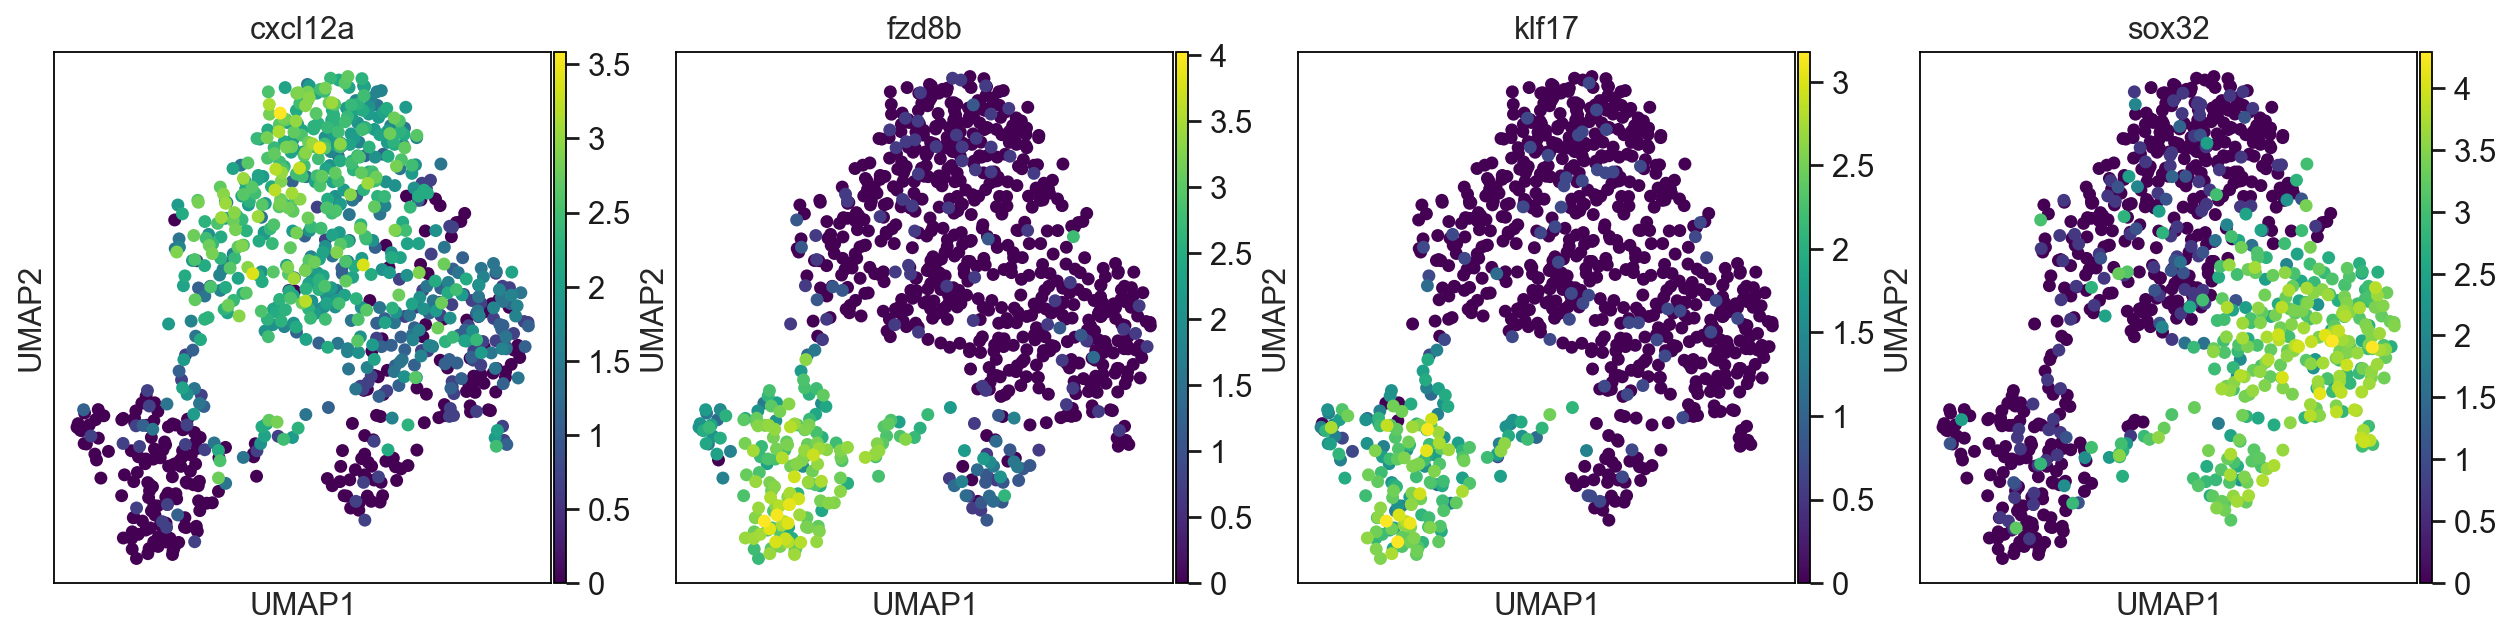

In [35]:
sc.pl.umap(adata, color=['cxcl12a', 'fzd8b', 'klf17','sox32'])

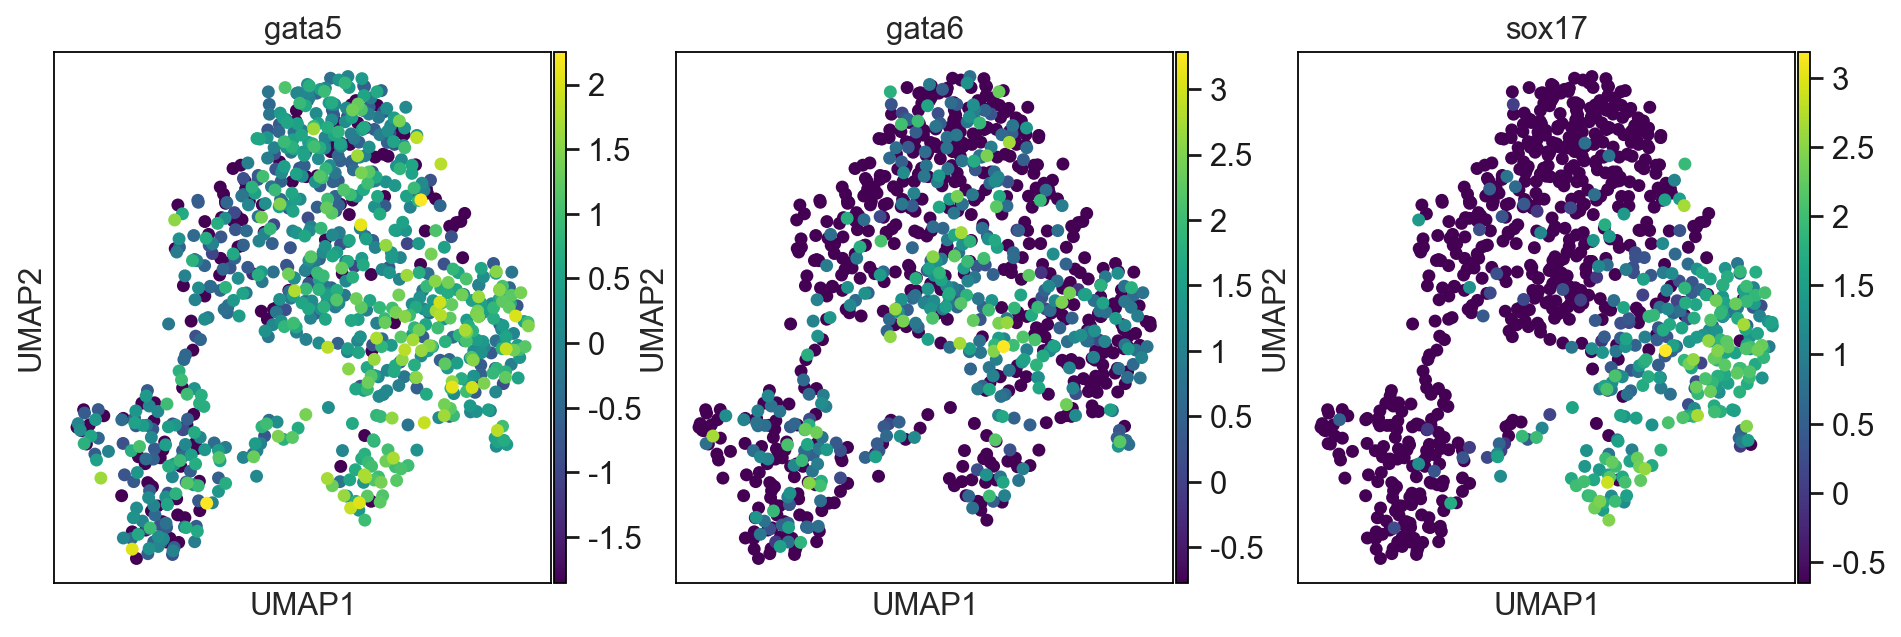

In [36]:
sc.pl.umap(adata, color=['gata5', 'gata6', 'sox17'], use_raw=False)

In [37]:
### Louvain
help(sc.tl.louvain)

Help on function louvain in module scanpy.tools.louvain:

louvain(adata, resolution=None, random_state=0, restrict_to=None, key_added=None, adjacency=None, flavor='vtraag', directed=True, copy=False)
    Cluster cells into subgroups [Blondel08]_ [Levine15]_ [Traag17]_.
    
    Cluster cells using the Louvain algorithm [Blondel08]_ in the implementation
    of [Traag17]_. The Louvain algorithm has been proposed for single-cell
    analysis by [Levine15]_.
    
    This requires to run :func:`~scanpy.api.pp.neighbors`, first.
    
    Parameters
    ----------
    adata : :class:`~scanpy.api.AnnData`
        The annotated data matrix.
    resolution : `float` or `None`, optional (default: 1)
        For the default flavor ('vtraag'), you can provide a resolution (higher
        resolution means finding more and smaller clusters), which defaults to
        1.0.
    random_state : `int`, optional (default: 0)
        Change the initialization of the optimization.
    restrict_to : `tuple`

In [38]:
sc.tl.louvain(adata, resolution = 0.3)


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.24) --> found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


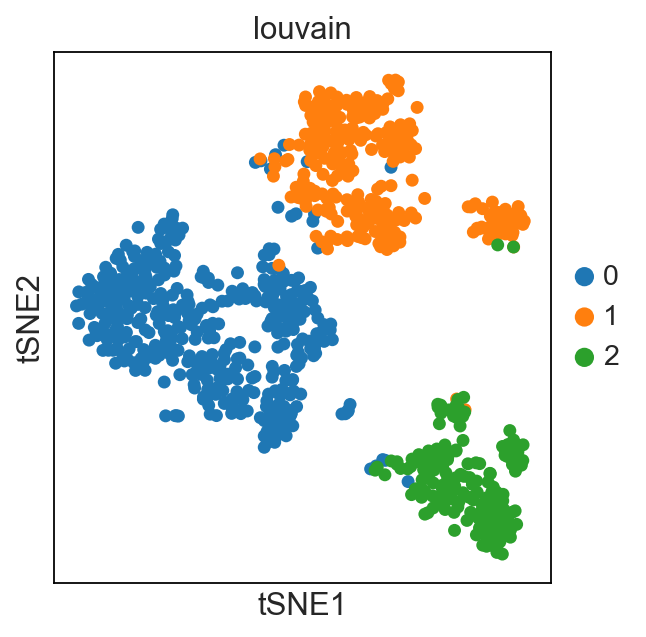

In [39]:
sc.pl.tsne(adata, color='louvain')

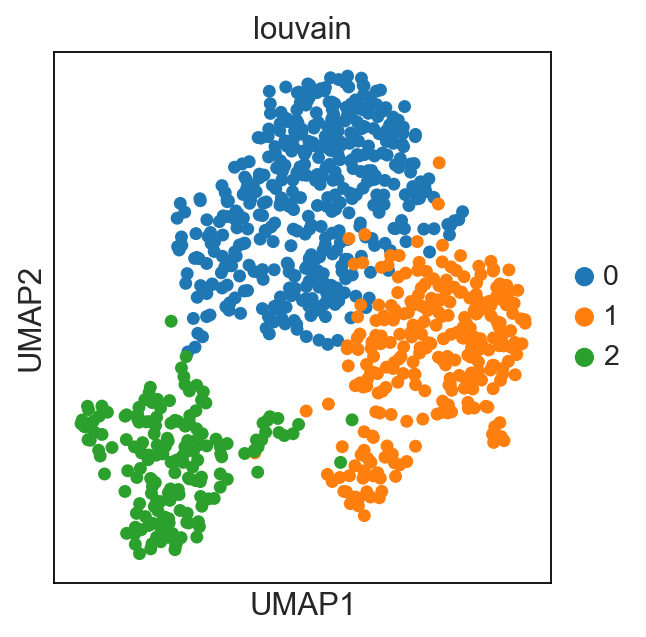

In [40]:
sc.pl.umap(adata, color='louvain')

In [41]:
adata.write(results_file)

In [42]:
### Marker Genes

ranking genes
    finished (0:00:00.65)
saving figure to file ./figures/rank_genes_groups_louvain.pdf


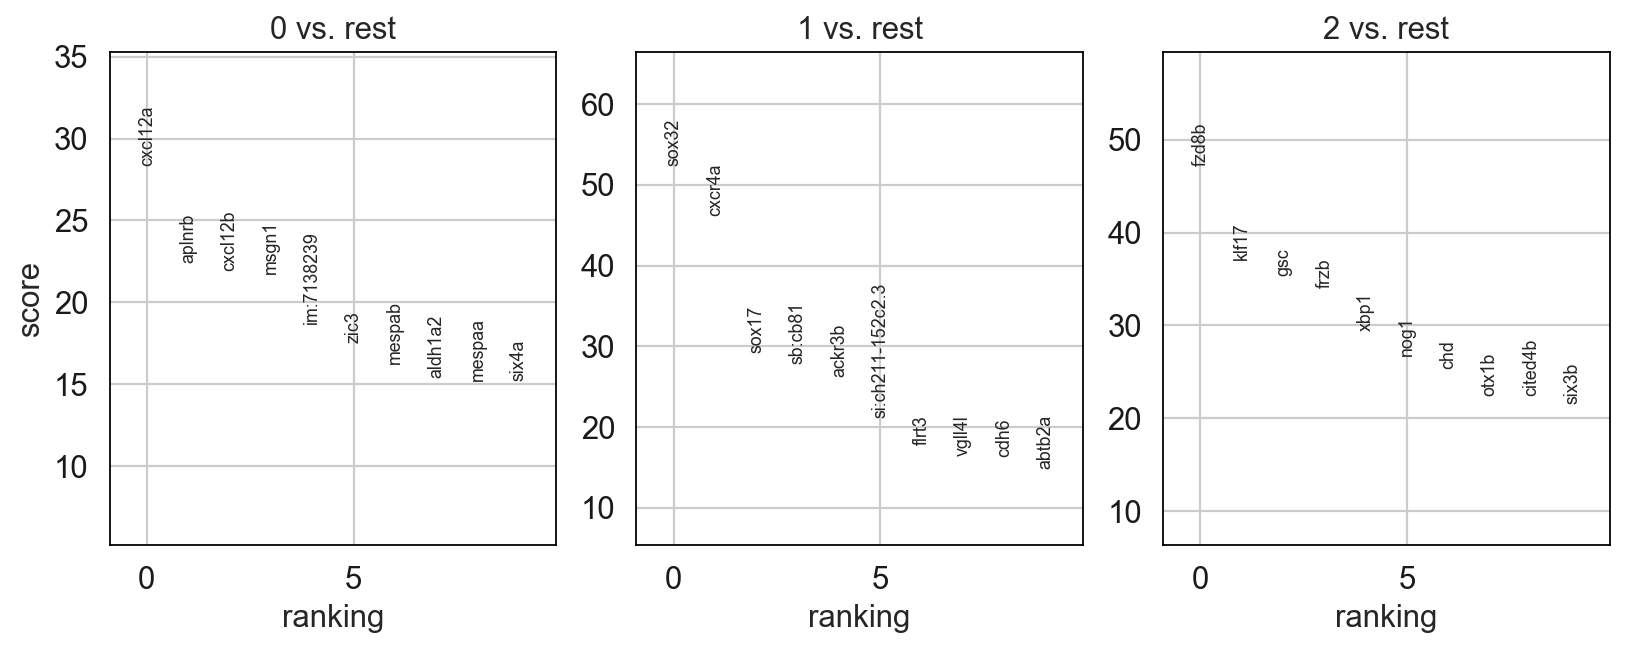

In [53]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain')
sc.pl.rank_genes_groups(adata, n_genes=10, save='.pdf')
adata.write(results_file)

In [44]:
sc.settings.verbosity = 2  # reduce the verbosity to no longer see hints

ranking genes
    finished (0:00:03.11)


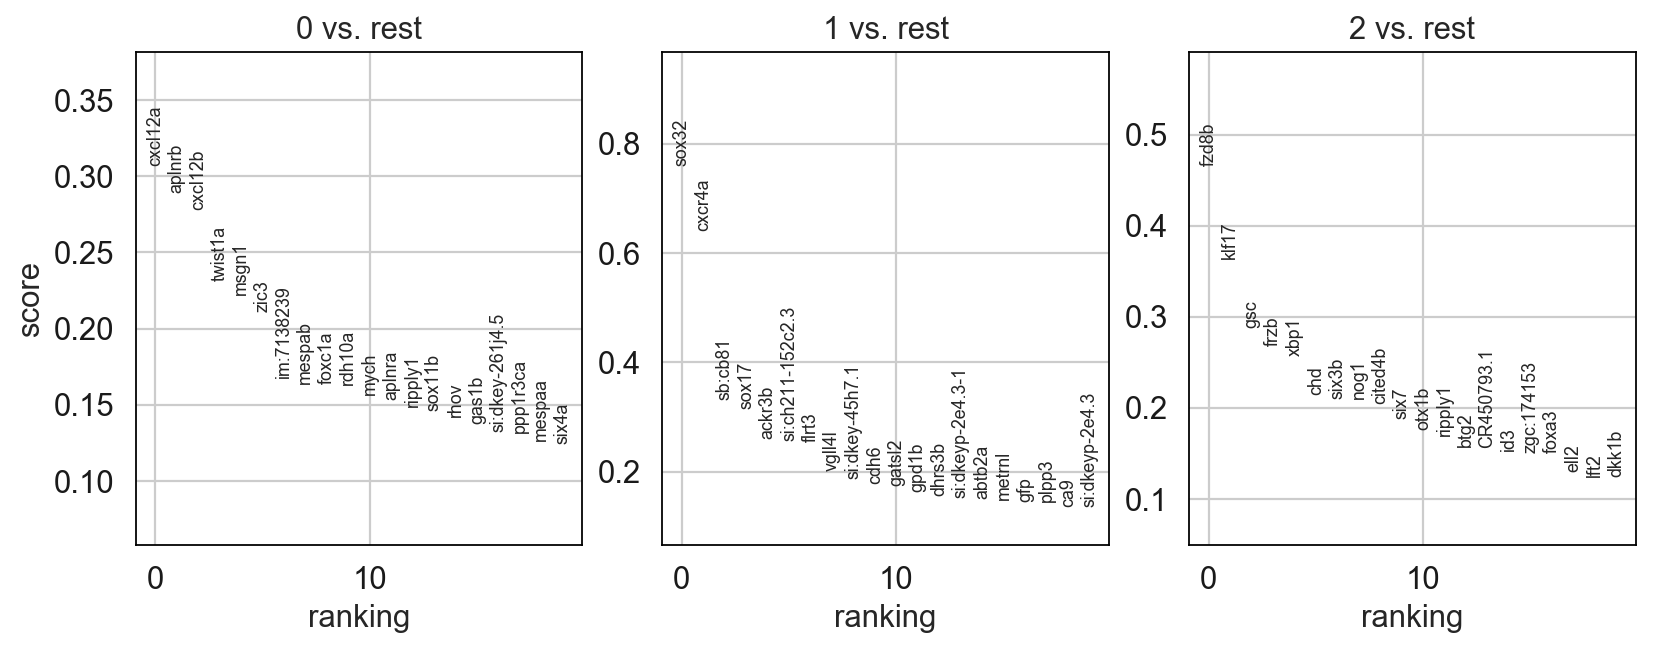

In [45]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=20)

In [46]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2
0,cxcl12a,sox32,fzd8b
1,aplnrb,cxcr4a,klf17
2,cxcl12b,sb:cb81,gsc
3,twist1a,sox17,frzb
4,msgn1,ackr3b,xbp1


In [47]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(5)

,0_n,0_s,1_n,1_s,2_n,2_s
0,cxcl12a,0.306834,sox32,0.759628,fzd8b,0.465685
1,aplnrb,0.289319,cxcr4a,0.641515,klf17,0.363468
2,cxcl12b,0.278155,sb:cb81,0.330645,gsc,0.287284
3,twist1a,0.231567,sox17,0.314384,frzb,0.268092
4,msgn1,0.222264,ackr3b,0.260866,xbp1,0.257196


ranking genes
    finished (0:00:00.27)


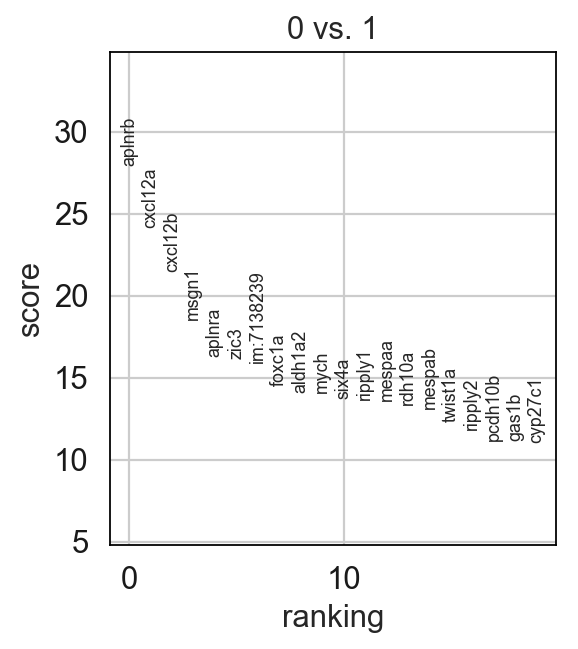

In [48]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

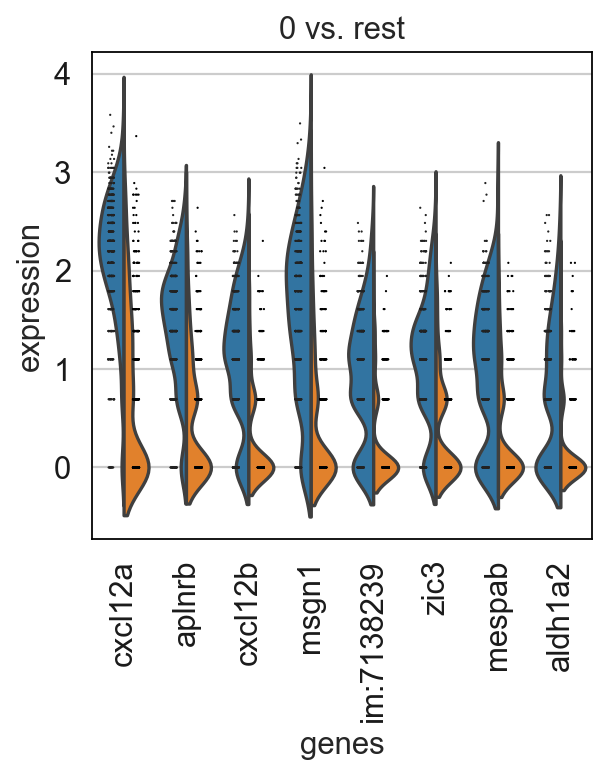

In [61]:
sc.pl.rank_genes_groups_violin(adata, groups=('0','2'), n_genes=8)

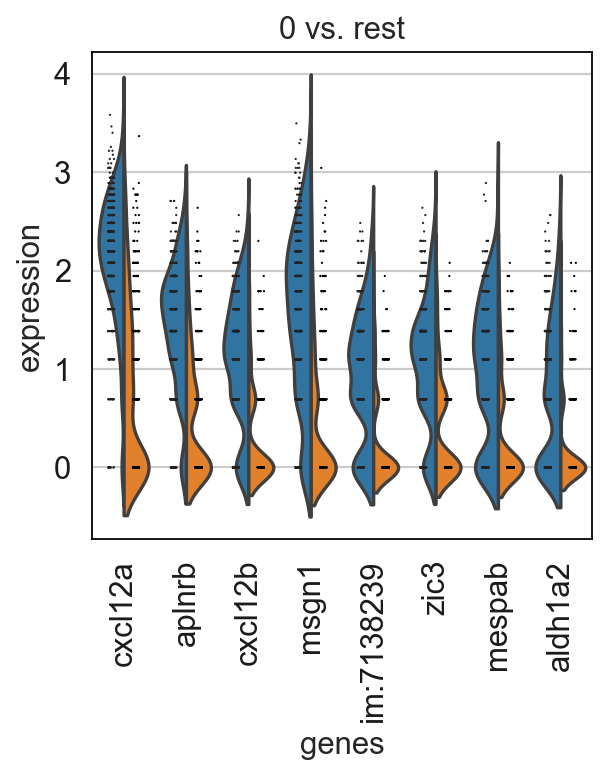

In [50]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

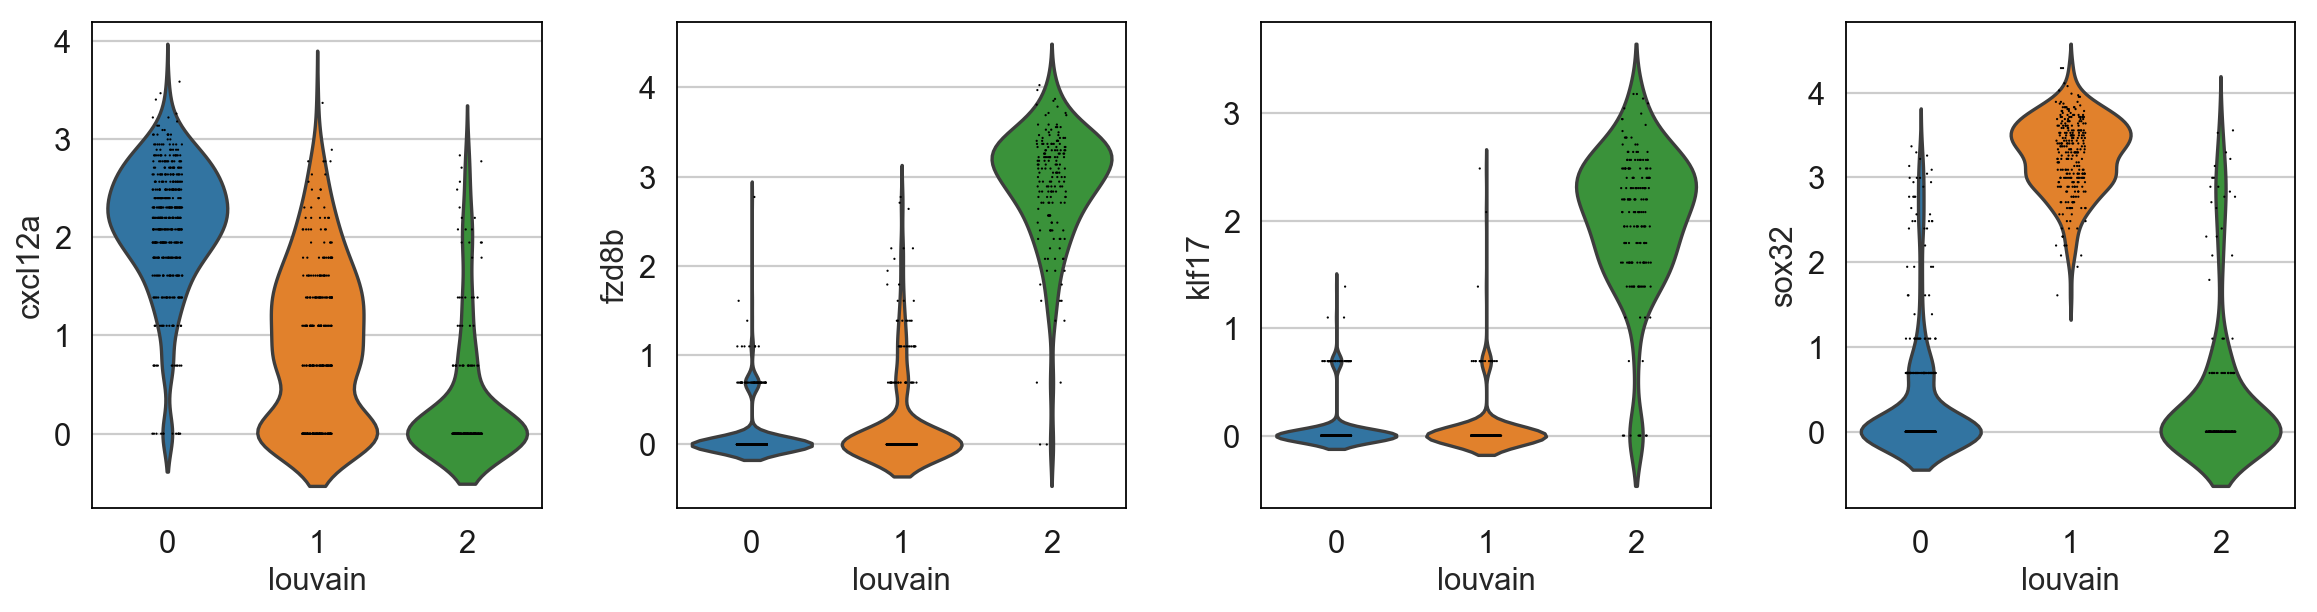

In [62]:
sc.pl.violin(adata, ['cxcl12a', 'fzd8b', 'klf17','sox32'], groupby='louvain')

In [52]:
# HELPER FUNCTIONS

def load_genes(filename, delimiter='\t', column=0, skip_rows=0):
    gene_list = []
    gene_dict = {}

    with open(filename) as f:
        for iL in range(skip_rows):
            f.readline()
        for l in f:
            gene = l.strip('\n').split(delimiter)[column]
            gene = gene.replace("/", "\/")
            if gene in gene_dict:
                gene_dict[gene] += 1
                gene_list.append(gene + '__' + str(gene_dict[gene]))
                if gene_dict[gene] == 2:
                    i = gene_list.index(gene)
                    gene_list[i] = gene + '__1'
            else: 
                gene_dict[gene] = 1
                gene_list.append(gene)
    return gene_list

def load_text(file_data,delim='\t'):
    X_data = []
    X_row = []
    X_col = []

    start_column = -1
    start_row = -1
    for row_ix, dat in enumerate(file_data):
        dat = dat.strip('\n').split(delim)

        if start_row == -1:
            current_col = 0
            found_float = False
            while not found_float and current_col < len(dat):
                try: 
                    tmp = float(dat[current_col])
                    
                    try:
                        rowdat = np.array(map(float, dat[current_col:]))
                        ncol = len(rowdat)
                        col_ix = np.nonzero(rowdat)[0]

                        found_float = True
                        start_row = row_ix
                        start_column = current_col

                        X_col.extend(col_ix)
                        X_row.extend([row_ix - start_row] * len(col_ix))
                        X_data.extend(rowdat[col_ix])

                    except:
                        current_col += 1

                except:
                    current_col += 1
        else:
            try:
                rowdat = np.array(map(float, dat[start_column:]))
                if len(rowdat) != ncol:
                    return 'ERROR: Rows have different numbers of numeric columns.'
                col_ix = np.nonzero(rowdat)[0]
                X_col.extend(col_ix)
                X_row.extend([row_ix - start_row] * len(col_ix))
                X_data.extend(rowdat[col_ix])
            except:
                return 'ERROR: Rows have different numbers of numeric columns.'

    if start_row == -1:
        return 'ERROR: no numeric values found'

    nrow = row_ix - start_row + 1
    E = scipy.sparse.coo_matrix((X_data, (X_row, X_col)), dtype=float, shape=(nrow, ncol)).tocsc()
    
    return E

def file_opener(filename):
    fileData = open(filename)
    if filename.endswith('.gz'):
        import gzip
        outData = gzip.GzipFile(fileobj = fileData, mode = 'rb')
    elif filename.endswith('.zip'):
        import zipfile
        zipData = zipfile.ZipFile(fileData, 'r')
        fnClean = filename.strip('/').split('/')[-1][:-4]
        outData = zipData.open(fnClean)
    else:
        outData = fileData
    return outData
